<a href="https://colab.research.google.com/github/marionwenger/DLColabNotebooks/blob/main/notebooks/07_cifar10_tricks_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar10 classification tricks

In this notebook you will download the cifar10 dataset which contains quite small images (32x32x3) of 10 classes. The data is from the Canadian Institute For Advanced Research. You will plot examples of the images with the class label. Note that because the images are so small it is not always very easy to recognise which of the ten classes is on the image, even as a human. After loading the dataset you will train multiple models and compare the performances of the models on the testset.

**Dataset:**  You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

**Content:**
* load the original cifar10 data create a train val and test dataset
* visualize samples of cifar10 dataset

* train a random forest on the pixelvalues
* train a cnn from scratch without normalization
* train a cnn from scratch with normalization
* train a cnn from scratch with dropout
* train a cnn from scratch with batchnorm
* train a cnn from scratch with data augmentation

* compare the performances of the models


#### Imports

In the next two cells, we load all the required libraries and functions.

In [1]:
# load required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from sklearn.ensemble import RandomForestClassifier



### Load and plot the data

In the next cell you will load the Cifar10 dataset, 50'000 images are in the training set and 10'000 are in the test dataset. You will use 10'000 for the train and validation dataset.
You will plot one random example of each label and will see
that the images are really small and finally you can convert the lables into the one hot encoding.


In [2]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# separate train val and test dataset
X_train=x_train[0:10000]
Y_train=to_categorical(y_train[0:10000],10) # one-hot encoding

X_val=x_train[20000:30000]
Y_val=to_categorical(y_train[20000:30000],10)

X_test=x_test
Y_test=to_categorical(y_test,10)

del x_train, y_train, x_test, y_test


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


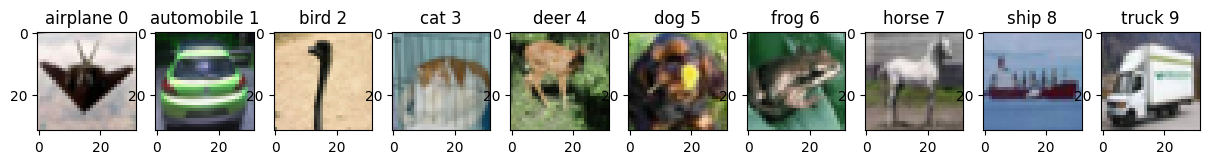

In [4]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(15,15))
for i in range(0,len(np.unique(np.argmax(Y_train,axis=1)))):
    rmd=np.random.choice(np.where(np.argmax(Y_train,axis=1)==i)[0],1)
    plt.subplot(1,10,i+1)
    img=X_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+str(np.argmax(Y_train,axis=1)[rmd][0]))

In [5]:
# check the shape of the data
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((10000, 32, 32, 3), (10000, 10), (10000, 32, 32, 3), (10000, 10))

### RF on pixelvalues
In this section you will train a random forest on the raw pixelvalues of the images.


In [6]:
clf = RandomForestClassifier(n_estimators=100,random_state=22)
clf.fit(X_train.reshape(len(X_train),32*32*3), np.argmax(Y_train,axis=1))

RandomForestClassifier(random_state=22)

In [7]:
pred=clf.predict(X_test.reshape(len(X_test),32*32*3))
acc=np.average(pred==np.argmax(Y_test,axis=1))
res1 = pd.DataFrame(
          {'Acc' : acc}, index=['rf on pixelvalues'])
res1

,Acc
rf on pixelvalues,0.4208


### CNN from scratch without normalization
In this section you train a cnn from scratch to learn to classify the images into the right label. Normalization is not applied to the data.

In [8]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                   

In [10]:
history = model.fit(X_train, Y_train,
                    batch_size=64,
                    epochs=10, validation_data=(X_val, Y_val),verbose=0) # 1)

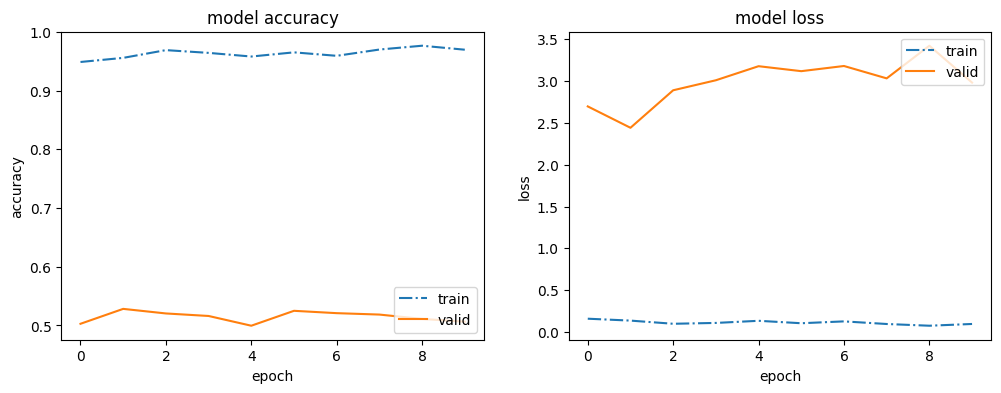

In [11]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [12]:
acc=np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res2 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch without normalization']
)
pd.concat([res1,res2])

313/313 [==============================] - 1s 2ms/step


,Acc
rf on pixelvalues,0.4208
cnn from scratch without normalization,0.5028


from matplotlib import pyplot as plt
_df_0['Acc'].plot(kind='hist', bins=20, title='Acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Acc']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Acc'}, axis=1)
              .sort_values('Acc', ascending=True))
  xs = counted['Acc']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Acc', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Acc')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_2['Acc'].plot(kind='line', figsize=(8, 4), title='Acc')
plt.gca().spines[['top', 'right']].set_visible(False)

### CNN from scratch with normalization
In this section you train a cnn from scratch to learn to classify the images into the right label. Normalization is applied to the data.

In [13]:
# normalization
X_train_norm = X_train/255
X_val_norm = X_val/255
X_test_norm = X_test/255

In [14]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

In [15]:
history = model.fit(X_train_norm, Y_train,
                    batch_size=64,
                    epochs=10, validation_data=(X_val_norm, Y_val),verbose=0) # 1)

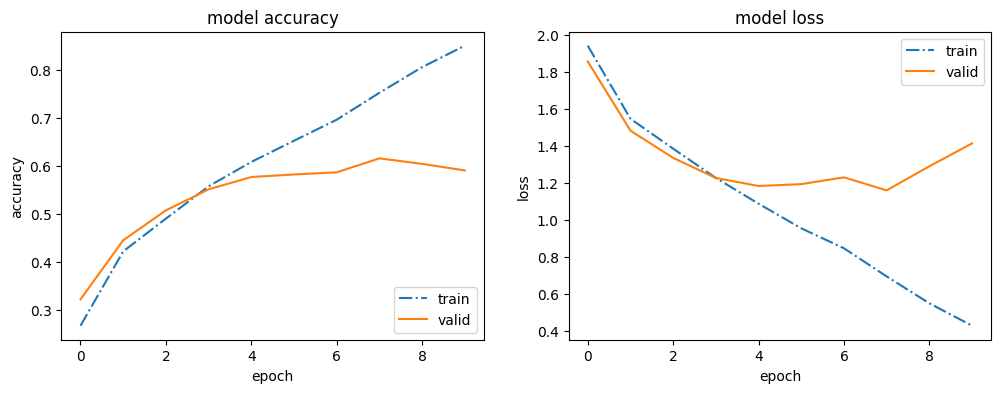

In [16]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [17]:
acc=np.average(np.argmax(model.predict(X_test_norm),axis=1)==np.argmax(Y_test,axis=1))
res3 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with normalization']
)
pd.concat([res1,res2,res3])

313/313 [==============================] - 1s 2ms/step


,Acc
rf on pixelvalues,0.4208
cnn from scratch without normalization,0.5028
cnn from scratch with normalization,0.5820


### CNN from scratch with Dropout
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use dropout layers in the classification part. Normalization is not used.

In [18]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

In [19]:
history = model.fit(X_train, Y_train,
                    batch_size=64,
                    epochs=20, validation_data=(X_val, Y_val),verbose=0) #1)

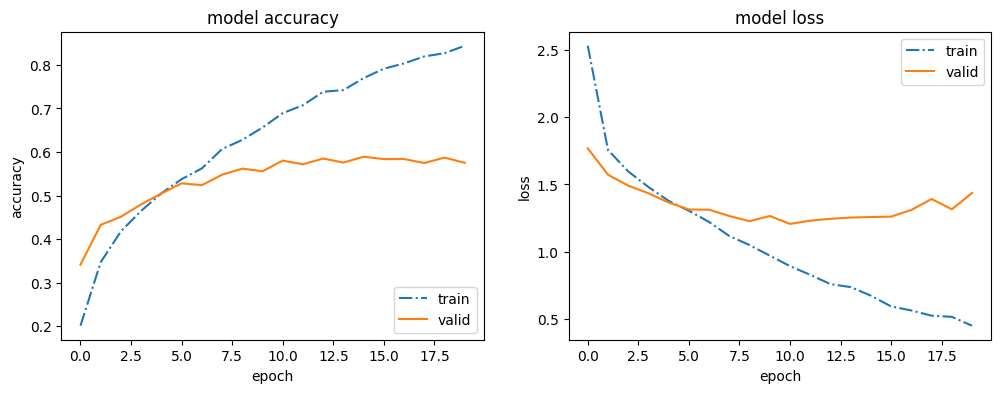

In [ ]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [20]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res4 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with dropout']
)
pd.concat([res1,res2,res3,res4])

313/313 [==============================] - 1s 2ms/step


,Acc
rf on pixelvalues,0.4208
cnn from scratch without normalization,0.5028
cnn from scratch with normalization,0.5820
cnn from scratch with dropout,0.5817


### CNN from scratch with Batchnorm
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use batchnorm on the input and in the convolutional part of the network. Note that we use the original images and do not normalize them.

In [21]:
# not normalized, values between 0 and 255
X_train[0,0:10,0,0]

array([ 59,  16,  25,  33,  50,  71,  97, 115, 137, 154], dtype=uint8)

In [22]:
model  =  Sequential()

model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(16,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(32,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 32, 32, 3)         12        
 Normalization)                                                  
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 32, 32, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32, 16)       

In [23]:
history = model.fit(X_train, Y_train,
                    batch_size=64,
                    epochs=10, validation_data=(X_val, Y_val),verbose=0) #1)

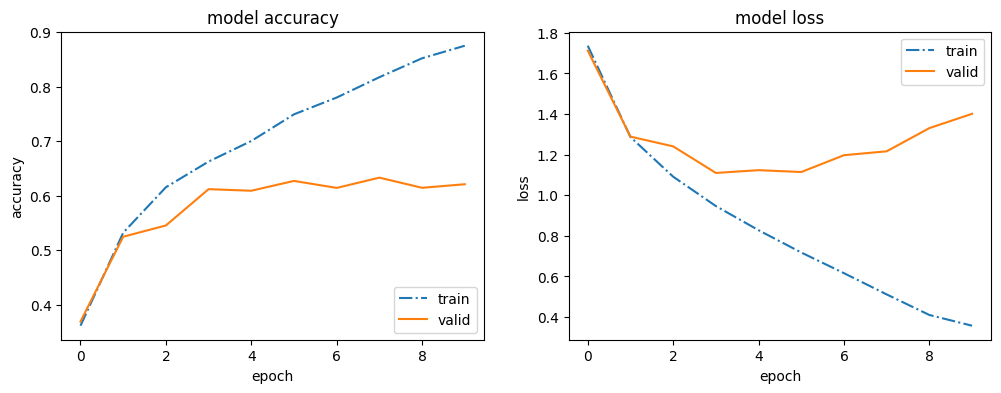

In [24]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [25]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res5 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with batchnorm']
)
pd.concat([res1,res2,res3,res4,res5])

313/313 [==============================] - 1s 2ms/step


,Acc
rf on pixelvalues,0.4208
cnn from scratch without normalization,0.5028
cnn from scratch with normalization,0.5820
cnn from scratch with dropout,0.5817
cnn from scratch with batchnorm,0.6130


#### Exercise
Calculate the confusion matrix of the networks.  
Play around with the dropout rate and the position of the batchnorm.

Accuracy =  0.613 for cnn from scratch with batchnorm


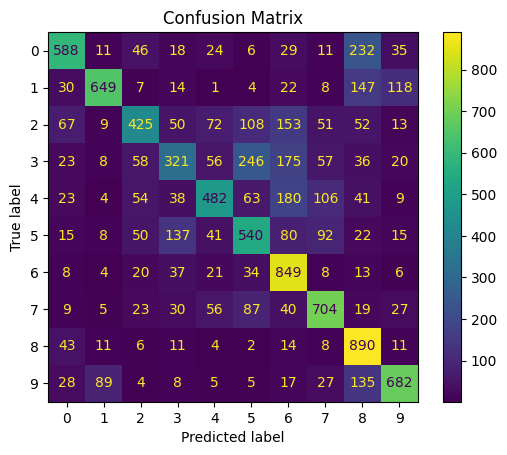

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predict each instance of the testset
pred=model.predict(X_test, verbose = 0)
# get confusion matrix
cm = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(pred,axis=1))

acc_fc = np.sum(np.argmax(Y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Accuracy = " , acc_fc, "for cnn from scratch with batchnorm")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

### CNN from scratch with Data Augmentation
In this section you train a cnn from scratch to learn to classify the images into the right label. This time you will use data augmentation, so the network will train on slightly different versions of the images in each epoch.

Data Augmentation is especially helpful if you do not have lots of data. Another approach to train with few data is to use a pretrained neural network. This will be covered in the next notebook.

In [28]:
model  =  Sequential()

model.add(Convolution2D(16,(3,3),activation="relu",padding="same",input_shape=(32,32,3)))
model.add(Convolution2D(16,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(Convolution2D(32,(3,3),activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                 

In [29]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
fill_mode="constant",
cval=1,horizontal_flip=True)

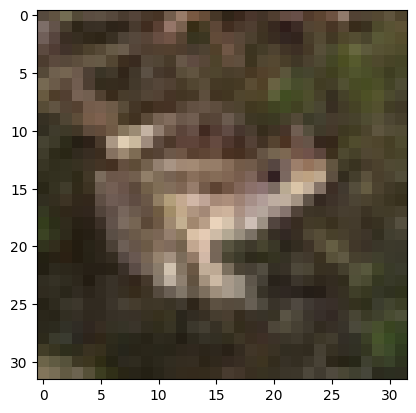

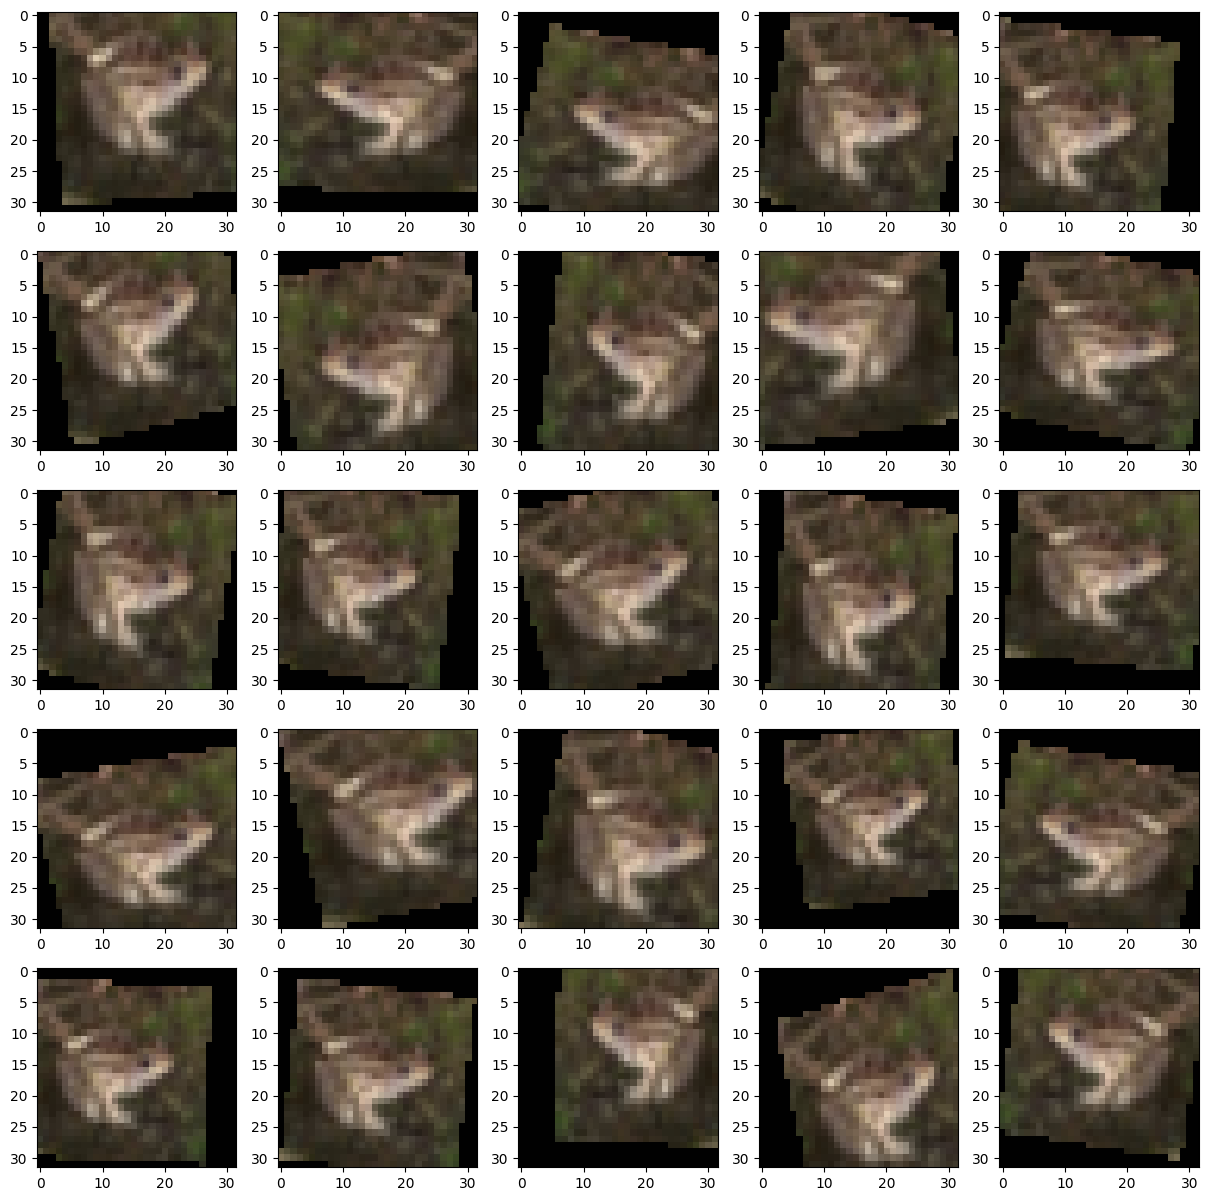

In [30]:
i=22
data_aug=datagen.flow(x=X_train[i:(i+1)], y=Y_train[i:(i+1)], batch_size=1)
plt.imshow(X_train[i])
plt.show()
plt.figure(figsize=(15,15))
for i in range (0,25):
    plt.subplot(5,5,i+1)
    x_aug,y_aug=next(data_aug)
    plt.imshow(x_aug[0].astype("int"), vmin = 0, vmax = 255)

In [33]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=64), # use model.fit instead, fit_generator is deprecated
                              steps_per_epoch=len(X_train)/64,
                              epochs=40,
                              validation_data=(X_val, Y_val),
                              verbose=0) #1)

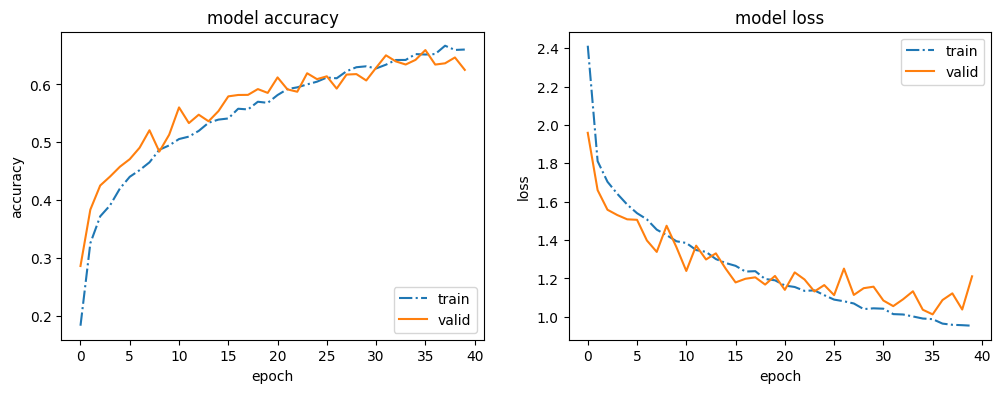

In [ ]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [ ]:
acc = np.average(np.argmax(model.predict(X_test),axis=1)==np.argmax(Y_test,axis=1))
res6 = pd.DataFrame(
          {'Acc' : acc}, index=['cnn from scratch with data augmentation']
)
pd.concat([res1,res2,res3,res4,res5,res6])

313/313 [==============================] - 2s 5ms/step


,Acc
rf on pixelvalues,0.3930
cnn from scratch without normalization,0.5038
cnn from scratch with normalization,0.5942
cnn from scratch with dropout,0.5761
cnn from scratch with batchnorm,0.6041
cnn from scratch with data augmentation,0.6248


#### Exercise
Try to beat the performace of the best network with your own neural network.  
*Hint: You might want to combine things from the neural networks above*

In [ ]:
# ist auf kaggle mit acc sehr hoch

# immer: data augmentation & standardization und entweder dropout oder batch norm

# ohne data generator kommt man eigentlich immer auf train loss = 0

# generator: Bilder werden dynamisch erstellt und nicht abgespeichert

# bei diesem Datensatz kommt man vermutlich auf 0.88 oder 0.9